In this tutorial, we’ll guide you through creating a multimodal database using LanceDB, Groq, and Hugging Face. We'll be:

- Using the [HuggingFace Hub](https://huggingface.co/) to download a text and image embedding model
- Using [Groq](https://groq.com/) to generate image captions using the latest Llama 3.2 Vision 90B model
- Using [LanceDB](https://lancedb.github.io/lancedb/) to create a true multimodal database

By the end of this tutorial, you'll have a fully functional multimodal database with text and image embeddings, as well as image captions. This setup will allow us to search for images using both other images and text. You can find this notebook and additional resources in [this GitHub respository](https://github.com/pedrojrv/multi-modal-demo). There are numerous excellent resources for diving deep into embeddings, so I’ll keep explanations concise.

Let’s get started by installing the dependencies we'll need.

Full disclosure: I chose these technologies for experimentation and learning (and because they’re free).

In [ ]:
!pip install groq lancedb torch transformers huggingface_hub Pillow matplotlib

## Text Embeddings

Text embeddings represent text as vectors. These vectors can be used to compare the similarity between different texts. We will use the HuggingFace Hub to download [BGE Small English Version 1.5](https://huggingface.co/BAAI/bge-small-en-v1.5), a lightweight model that performs well enough for our example.

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-small-en-v1.5')
model = AutoModel.from_pretrained('BAAI/bge-small-en-v1.5')
_ = model.eval()

Text embeddings allow us to compare the similarity between different texts. Many great resources are available for a deep dive into text embeddings, so we won't go into too much detail here.

In [ ]:
def get_embedding(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        # Perform pooling. In this case, cls pooling.
        sentence_embeddings = model_output[0][:, 0]

    # normalize embeddings
    sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
    # sentence_embeddings = sentence_embeddings.tolist()
    return sentence_embeddings


Now, let's get the text embeddings for three different texts to quickly showcase how it works.

In [ ]:
hello = "hello"
hi = "hi"
bye = "bye"

hello_emb = get_embedding(hello)
hi_emb = get_embedding(hi)
bye_emb = get_embedding(bye)

In [ ]:
print("Length of hello embedding: ", len(hello_emb[0]))
print("First 10 elements of hello embedding: ", hello_emb[0][:10])

Length of hello embedding:  384
First 10 elements of hello embedding:  tensor([-0.0644, -0.0628,  0.0597, -0.0625, -0.0131,  0.0182,  0.0686,  0.0358,
         0.0408,  0.0051])


There are various distance metrics that can be used to compare the similarity between two vectors. We will use the cosine similarity metric, which calculates the cosine of the angle between two vectors. The closer the cosine similarity is to 1, the more similar the two vectors are

In [ ]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [ ]:
hello_hi_sim = cos(hello_emb, hi_emb)
print("Similarity between hello and hi: ", hello_hi_sim.item())

Similarity between hello and hi:  0.923446536064148


In [ ]:
hello_bye_emb = cos(hello_emb, bye_emb)
print("Similarity between hello and bye: ", hello_bye_emb.item())

Similarity between hello and bye:  0.7023690938949585


You can see that `hello` and `hi` are more similar than `hello` and `bye`. We now have a model capable of generating text embeddings, so let's move on to image embeddings.

## Image Embeddings

Image embeddings represent images as vectors. These vectors can be used to compare the similarity between different images, among other applications. We will use one of Google’s [ViTs](https://huggingface.co/google/vit-base-patch16-224-in21k) models to generate image embeddings.

In [ ]:
import io
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTModel

In [ ]:
vit_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
_ = vit_model.eval()

I already have a couple of images stored in a local folder. These include some photos I took, featuring two of my dogs. Let’s take a quick look at them before generating the image embeddings.

In [ ]:
# If you are cloning this from Github append `../assets/` to the strings below
baby_loyer = "6003300256_b7b14998ce_o.jpg"
big_loyer = "20121230_152246.jpg"
flaca = "5764939091_e8cc04e65c_o.jpg"

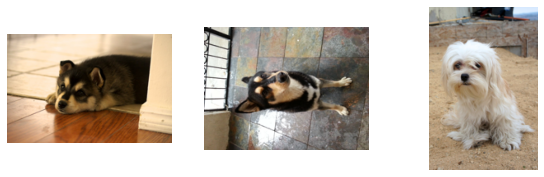

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, img_path in zip(axes, [baby_loyer, big_loyer, flaca]):
    img = Image.open(img_path)
    img.thumbnail((200, 200))  # Resize the image to fit within 200x200 pixels while keeping the aspect ratio
    ax.imshow(img)
    ax.axis('off')

plt.show()

Now, let's generate the image embeddings! Here, we write a function similar to the text embeddings one to generate the image embeddings.

In [ ]:
def generate_image_embeddings(image_path):
    batch_image = [Image.open(image_path)]

    # Process image
    inputs = vit_processor(images=batch_image, return_tensors="pt")

    # Compute image embeddings
    with torch.no_grad():
        outputs = vit_model(**inputs)
        # last_hidden_states = outputs.last_hidden_state
        image_embeddings = outputs.pooler_output

    # Normalize embeddings
    image_embeddings = torch.nn.functional.normalize(image_embeddings, p=2, dim=1)
    return image_embeddings

In [ ]:
baby_loyer_emb = generate_image_embeddings(baby_loyer)
big_loyer_emb = generate_image_embeddings(big_loyer)
flaca_emb = generate_image_embeddings(flaca)

In [ ]:
print("Length of baby_loyer embedding: ", len(baby_loyer_emb[0]))
print("First 10 elements of baby_loyer embedding: ", baby_loyer_emb[0][:10])

Length of baby_loyer embedding:  768
First 10 elements of baby_loyer embedding:  tensor([ 0.0221,  0.0107, -0.0476, -0.0253, -0.0162,  0.0383,  0.0372,  0.0509,
         0.0079, -0.0446])


In [ ]:
baby_big_sim = cos(baby_loyer_emb, big_loyer_emb)
print("Similarity between baby_loyer and big_loyer: ", baby_big_sim.item())

Similarity between baby_loyer and big_loyer:  0.6334121823310852


In [ ]:
baby_flaca_sim = cos(baby_loyer_emb, flaca_emb)
print("Similarity between baby_loyer and flaca: ", baby_flaca_sim.item())

Similarity between baby_loyer and flaca:  0.4711515009403229


You can see that baby and grown-up Loyer have a higher similarity to each other than Loyer does to my other dog, Flaca. We now have a model capable of generating image embeddings. Nothing too fancy—now let’s generate image captions.

## Image Captioning

How can we search for images using text? Image captioning is a way to generate a textual description of an image. Nowadays, we're seeing not only text-based models but also vision-enabled ones! This makes them very powerful for multimodal applications.

We’ll use Groq to generate image captions with the [Llama 3.2 Vision 90B](https://huggingface.co/meta-llama/Llama-3.2-90B-Vision-Instruct). This model can process both text and images to generate text. I actually tried using the HuggingFace Serverless API, but I couldn't get it to work. I’m sure it’s possible, but I couldn’t figure it out. I posted on the forums with no luck (if you know how, please comment). So I decided to use Groq instead—and it turned out to be amazing!

In [ ]:
import os
import base64

from groq import Groq

Make sure GROQ_API_KEY environment variable is set with your Groq API key. You can get one by signing up at [Groq](https://console.groq.com/playground).

In [ ]:
# HEX allows me to reference my secret using backend set keys, make sure to replace with your own
client = Groq(
    api_key=GROQ_API_KEY
)

Similar to the text and image embeddings, we will create a function to generate captions for images.

In [ ]:
def get_image_caption(image_path):
    with open(image_path, "rb") as image_file:
        input_image = base64.b64encode(image_file.read()).decode('utf-8')

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Create a detailed caption for the attached image."}
            ]
        }
    ]

    messages[0]["content"].append(
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{input_image}",
            },
        }
    )

    chat_completion = client.chat.completions.create(
        messages=messages,
        model="llama-3.2-11b-vision-preview",
        temperature=0.5,
        max_tokens=1024,
        top_p=1,
        stream=False,
        stop=None,
    )
    return chat_completion.choices[0].message.content


Now lets generate the image captions for the images we have.

In [ ]:
baby_loyer_caption = get_image_caption(baby_loyer)
print("Caption for baby_loyer image: ", baby_loyer_caption)

Caption for baby_loyer image:  The attached image shows a small, fluffy puppy lying on a wooden floor, with its head resting on a white mat and its body positioned under a white pillar. The puppy has a black and tan coat, with a distinctive white stripe running down the center of its face. Its ears are perked up, and its eyes are cast downward, giving the impression that it is gazing at something on the floor.

The puppy's fur is thick and fluffy, with a soft, velvety texture. Its paws are small and delicate, with five toes on each paw. The puppy's nose is black, and its mouth is slightly open, revealing a few teeth.

The background of the image is out of focus, but it appears to be a room with white walls and a tiled floor. The overall atmosphere of the image is one of calmness and serenity, with the puppy's relaxed posture and gentle expression conveying a sense of contentment and tranquility.


In [ ]:
big_loyer_caption = get_image_caption(big_loyer)
print("Caption for big_loyer image: ", big_loyer_caption)

Caption for big_loyer image:  The image shows a dog sitting on a tiled floor, looking up at the camera. The dog is in the center of the image and appears to be a medium-sized dog with a black and white coat, tan markings on its face, and pointy ears. It is sitting on a tiled floor with a multicolored pattern of brown, gray, and red tiles. The dog is looking up at the camera, its head tilted slightly to the left. 

The background of the image is a wall with a window and a black metal grate. The overall atmosphere of the image is one of curiosity and friendliness, as the dog seems to be inviting the viewer to interact with it.


In [ ]:
flaca_caption = get_image_caption(flaca)
print("Caption for flaca image: ", flaca_caption)

Caption for flaca image:  The attached image shows a small, long-haired dog sitting on a dirt surface, possibly a construction site or a backyard. The dog is white and appears to be a Maltese or a similar breed, known for its long, silky coat. It has a black nose and dark eyes, and its fur is matted and dirty, suggesting it may not have been groomed recently.

The dog is sitting on a dirt surface that is covered with small rocks and pebbles. In the background, there are some construction materials, including a pile of lumber and a stack of bricks. There is also a piece of plywood or OSB board that appears to be part of a building's foundation.

Overall, the image suggests that the dog may be a stray or a pet that has been left behind, and it is in need of care and attention. The construction materials in the background add a sense of context to the image, implying that the dog may be living in a makeshift or temporary setting.


## Multimodal Database

We have our text embeddings, image embeddings, and image captions. Now we will use LanceDB to create a multimodal database. Why LanceDB? I heard from their team that they are doing some amazing work. I am not performing any benchmarks here, but the selling point (among many others) is that the data itself (images, bytes, etc.) is stored alongside the embeddings and metadata. There is no need to store the data in a separate location. This is a huge advantage for multimodal databases!

We will be able to search for images using text, text using images, images using images, etc. You can search via any combination of text and images. We will keep it simple and only search for images using text and images. We will leave the rest as an exercise for the reader to implement any search combination they want.

In [ ]:
import lancedb
import pandas as pd
import pyarrow as pa


Let's instantiate the LanceDB client and create a multimodal database.

We will create the multimodal database with 5 fields:

- `vector_img`: Image embeddings
- `vector_txt`: Text embeddings
- `text`: Image captions
- `image_name`: The path to the image
- `image`: The image binary itself (go LanceDB!)

In [ ]:
db = lancedb.connect("./lance.db")
db.drop_table("image_table", ignore_missing=True)

schema = pa.schema(
    [
        pa.field("vector_img", pa.list_(pa.float32(), list_size=768)),
        pa.field("vector_txt", pa.list_(pa.float32(), list_size=384)),
        pa.field("text", pa.string()),
        pa.field("image_name", pa.string()),
        pa.field("image", pa.binary()),
    ]
)
db.create_table("image_table", schema=schema)
image_table = db.open_table("image_table")


We have created our table; now let us insert some data. For the purposes of this tutorial, we will just make use of the data we have generated so far. It will be simple, but it gets the point across.

In [ ]:
vectors_img = [baby_loyer_emb, big_loyer_emb, flaca_emb]
vector_txt = [get_embedding(caption) for caption in [baby_loyer_caption, big_loyer_caption, flaca_caption]]
texts = [baby_loyer_caption, big_loyer_caption, flaca_caption]
images_paths = [baby_loyer, big_loyer, flaca]
images_as_bytes = [open(img, "rb").read() for img in images_paths]


to_add = [
    {
        "vector_img": vec_img.tolist()[0],
        "vector_txt": vec_txt.tolist()[0],
        "text": txt,
        "image_name": str(img_name),
        "image": img
    } for vec_img, vec_txt, txt, img_name, img in zip(vectors_img, vector_txt, texts, images_paths, images_as_bytes)
]

image_table.add(to_add)

Now we have our multimodal database containing text and image embeddings, along with image captions. Let's search for images using both text and images. We will write two quick functions to assist us in this search.

In [ ]:
def search_images_by_image(image: str) -> pd.DataFrame:
    vector = generate_image_embeddings(image)[0].tolist()
    return image_table.search(vector, vector_column_name='vector_img').to_pandas()

def search_images_by_text(text: str) -> pd.DataFrame:
    vector = get_embedding(text)[0].tolist()
    return image_table.search(vector, vector_column_name='vector_txt').to_pandas()

Notice how we define the vector_column_name. This is another powerful feature of LanceDB. Do you want to store something? Just define it!

We are almost done.

Let's get to the fun part: searching for images using text and images.

In [ ]:
loyer_results = search_images_by_image(baby_loyer)
loyer_results.head()

,vector_img,vector_txt,text,image_name,image,_distance
0,"[0.022100685, 0.010662324, -0.047613747, -0.02...","[0.008104879, -0.007955199, 0.03018262, 0.0337...","The attached image shows a small, fluffy puppy...",6003300256_b7b14998ce_o.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,0.000000
1,"[-0.007349301, -0.004382891, -0.07396043, -0.0...","[-0.013378796, -0.00456333, 0.026550662, 0.002...",The image shows a dog sitting on a tiled floor...,20121230_152246.jpg,b'\xff\xd8\xff\xe1EZExif\x00\x00II*\x00\x08\x0...,0.733176
2,"[-0.024714338, -0.036042985, -0.060201515, -0....","[0.018890325, -0.010478014, 0.0019704518, 0.05...","The attached image shows a small, long-haired ...",5764939091_e8cc04e65c_o.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,1.057697


Since we are using LanceDB, we should be able to load the image directly from the database, as we store the image binary itself.

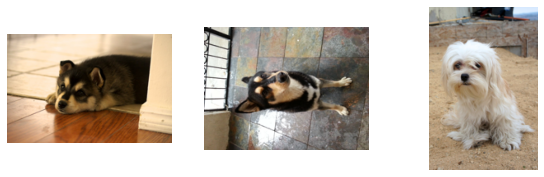

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, (_, row) in zip(axes, loyer_results.iterrows()):
    img = Image.open(io.BytesIO(row["image"]))
    img.thumbnail((200, 200))  # Resize the image to fit within 200x200 pixels while keeping the aspect ratio
    ax.imshow(img)
    ax.axis('off')

plt.show()

Impressive, right? Exactly the ordering we expected.

Now let's search for images using text.

In [ ]:
white_dog_results = search_images_by_text("white dog")
white_dog_results.head()

,vector_img,vector_txt,text,image_name,image,_distance
0,"[-0.024714338, -0.036042985, -0.060201515, -0....","[0.018890325, -0.010478014, 0.0019704518, 0.05...","The attached image shows a small, long-haired ...",5764939091_e8cc04e65c_o.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,0.616659
1,"[0.022100685, 0.010662324, -0.047613747, -0.02...","[0.008104879, -0.007955199, 0.03018262, 0.0337...","The attached image shows a small, fluffy puppy...",6003300256_b7b14998ce_o.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,0.672400
2,"[-0.007349301, -0.004382891, -0.07396043, -0.0...","[-0.013378796, -0.00456333, 0.026550662, 0.002...",The image shows a dog sitting on a tiled floor...,20121230_152246.jpg,b'\xff\xd8\xff\xe1EZExif\x00\x00II*\x00\x08\x0...,0.693188


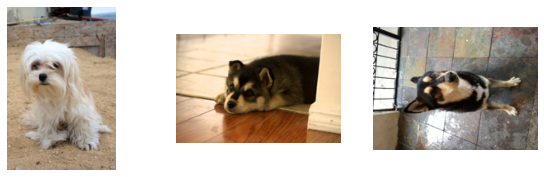

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, (_, row) in zip(axes, white_dog_results.iterrows()):
    img = Image.open(io.BytesIO(row["image"]))
    img.thumbnail((200, 200))  # Resize the image to fit within 200x200 pixels while keeping the aspect ratio
    ax.imshow(img)
    ax.axis('off')

plt.show()

Once again, the exact ordering! 

## Conclusion

We have created a multimodal database with text and image embeddings, as well as image captions. We were able to search for images using both text and images. We utilized the Hugging Face Hub to download a text and image embedding model, Groq to generate image captions, and LanceDB to create the multimodal database. We hope you found this tutorial helpful and informative. If you have any questions or feedback, please feel free to leave a comment.

Stay tuned! In our next tutorial, we will show you how to build a cool multimodal RAG application. Thank you for reading!

## Thoughts on Tech Used

### Groq

The ease of access and performance of models hosted by Groq is impressive. It allowed me to create this blog post, as an alternative to finding a provider and potentially paying per token out-of-pocket. Sometimes all we want to do is test the latest models, and Groq makes this easy.

### LanceDB

I loved how easy it is to use LanceDB. I have some benchmarks planned to compare it to other vector databases, but so far, so good. You saw how easy it is to interact and retrieve data. For the next blog post, I am using async methods, which unfortunately are not on parity with sync methods, making it sometimes difficult to develop, but more on that later.

### Hex

This is the first application (not sure if it counts as an app) that I host with Hex. It is very nice, but I found it very difficult to create this blog post for you all because of just one thing: I couldn't show the code cells. So, I had to copy and paste all code into markdown and enable the output of the actual code to show. Maybe I missed something.


Stay in touch:

- LinkedIn: [https://www.linkedin.com/in/pedrojrvv/](https://www.linkedin.com/in/pedrojrvv/)
- email: vicentepedrojr@gmail.com